<a href="https://colab.research.google.com/github/afrin764/aav_Supervised_and_semi_supervised/blob/main/SSLresnetRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Labeled:Unlabeled = 10:90 ===


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.1MB/s]


Epoch 1/10 Loss: 8.4236
Epoch 2/10 Loss: 6.1648
Epoch 3/10 Loss: 4.9574
Epoch 4/10 Loss: 5.5919
Epoch 5/10 Loss: 3.3844
Epoch 6/10 Loss: 2.9931
Epoch 7/10 Loss: 3.9057
Epoch 8/10 Loss: 3.6919
Epoch 9/10 Loss: 3.2398
Epoch 10/10 Loss: 3.2590
Accuracy: 86.86%
Per-Class Accuracy:
Double: 80.39%
Empty: 90.32%
Single: 90.91%

=== Labeled:Unlabeled = 20:80 ===
Epoch 1/10 Loss: 9.1506
Epoch 2/10 Loss: 4.7313
Epoch 3/10 Loss: 5.3014
Epoch 4/10 Loss: 4.8000
Epoch 5/10 Loss: 4.4385
Epoch 6/10 Loss: 2.9892
Epoch 7/10 Loss: 3.4492
Epoch 8/10 Loss: 3.1193
Epoch 9/10 Loss: 2.8807
Epoch 10/10 Loss: 3.0627
Accuracy: 89.05%
Per-Class Accuracy:
Double: 80.39%
Empty: 90.32%
Single: 96.36%

=== Labeled:Unlabeled = 30:70 ===
Epoch 1/10 Loss: 8.0399
Epoch 2/10 Loss: 5.4759
Epoch 3/10 Loss: 5.4491
Epoch 4/10 Loss: 3.7575
Epoch 5/10 Loss: 3.8148
Epoch 6/10 Loss: 2.9864
Epoch 7/10 Loss: 3.8552
Epoch 8/10 Loss: 2.9598
Epoch 9/10 Loss: 2.4613
Epoch 10/10 Loss: 2.4798
Accuracy: 87.59%
Per-Class Accuracy:
Double: 

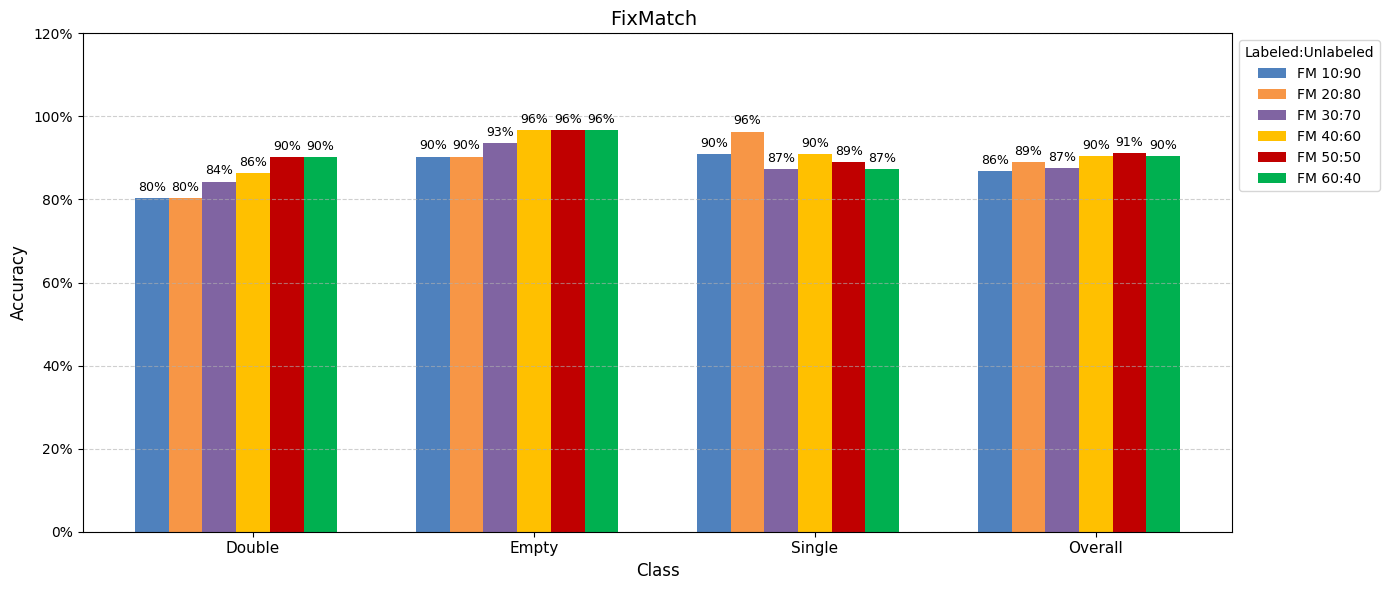

In [ ]:
# Install dependencies
!pip install torchvision scikit-learn matplotlib seaborn --quiet

import os, cv2, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Config
DATA_PATH = '/content/drive/MyDrive/100_4s_train_val_photos'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
CONF_THRESHOLD = 0.8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load image data
def load_data(path):
    X, y = [], []
    for root, _, files in os.walk(path):
        label = os.path.basename(root)
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(os.path.join(root, f))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

X, y = load_data(DATA_PATH)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Train/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Transforms
def get_transforms(img_size):
    weak = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    strong = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor()
    ])
    eval_tf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    return weak, strong, eval_tf

# FixMatch Dataset
class FixMatchDataset(Dataset):
    def __init__(self, X_l, y_l, X_u, weak_tf, strong_tf):
        self.X_l, self.y_l, self.X_u = X_l, y_l, X_u
        self.weak_tf, self.strong_tf = weak_tf, strong_tf
    def __len__(self):
        return max(len(self.X_l), len(self.X_u))
    def __getitem__(self, idx):
        x_l = self.weak_tf(self.X_l[idx % len(self.X_l)])
        y_l = self.y_l[idx % len(self.X_l)]
        x_u = self.X_u[idx % len(self.X_u)]
        return x_l, y_l, self.weak_tf(x_u), self.strong_tf(x_u)

# Load ResNet50
def get_model(name, num_classes):
    if name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Only resnet50 supported")
    return model.to(DEVICE), IMG_SIZE

# Train FixMatch
def train_fixmatch(model, train_loader, epochs=EPOCHS, conf_thresh=CONF_THRESHOLD):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        total_loss = 0
        for x_l, y_l, x_u_w, x_u_s in train_loader:
            x_l, y_l = x_l.to(DEVICE), y_l.to(DEVICE)
            x_u_w, x_u_s = x_u_w.to(DEVICE), x_u_s.to(DEVICE)

            logits_x = model(x_l)
            loss_x = criterion(logits_x, y_l)

            with torch.no_grad():
                probs = model(x_u_w)
                probs = torch.softmax(probs, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(conf_thresh).float()

            logits_u = model(x_u_s)
            loss_u = (criterion(logits_u, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss:.4f}")
    return model

# Feature Extractor
def get_feature_extractor(name):
    if name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        model.fc = nn.Identity()
    else:
        raise ValueError("Only resnet50 supported")
    return model.to(DEVICE)

# Extract features
def extract_features(model, X, eval_transform):
    model.eval()
    features = []
    with torch.no_grad():
        for img in X:
            x = eval_transform(img).unsqueeze(0).to(DEVICE)
            feat = model(x)
            features.append(feat.cpu().numpy())
    return np.vstack(features)

# Evaluate with MLP
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
overall_accuracies = []
per_class_accuracies_all = []

for ratio in split_ratios:
    print(f"\n=== Labeled:Unlabeled = {int(ratio*100)}:{int((1-ratio)*100)} ===")
    X_l, X_u, y_l, _ = train_test_split(X_trainval, y_trainval, test_size=(1 - ratio), stratify=y_trainval, random_state=42)

    model, img_size = get_model('resnet50', num_classes)
    weak_tf, strong_tf, eval_tf = get_transforms(img_size)
    train_dataset = FixMatchDataset(X_l, y_l, X_u, weak_tf, strong_tf)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = train_fixmatch(model, train_loader)

    feat_model = get_feature_extractor('resnet50')
    feat_model.load_state_dict(model.state_dict(), strict=False)
    X_l_feat = extract_features(feat_model, X_l, eval_tf)
    X_test_feat = extract_features(feat_model, X_test, eval_tf)

    mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=500)
    mlp.fit(X_l_feat, y_l)
    y_pred = mlp.predict(X_test_feat)
    acc = accuracy_score(y_test, y_pred)
    overall_accuracies.append(acc * 100)
    print(f"Accuracy: {acc*100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    class_acc = (cm.diagonal() / cm.sum(axis=1)) * 100
    per_class_accuracies_all.append(class_acc)

    print("Per-Class Accuracy:")
    for i, cname in enumerate(le.classes_):
        print(f"{cname}: {class_acc[i]:.2f}%")

# === Final Styled Grouped Bar Plot (Per-Class + Overall) ===
per_class_accuracies_all = np.array(per_class_accuracies_all)
x_labels = list(le.classes_) + ["Overall"]
split_labels = [f"FM {int(r*100)}:{int((1-r)*100)}" for r in split_ratios]

# Combine per-class + overall
combined_accuracies = []
for i in range(len(split_ratios)):
    combined_accuracies.append(np.append(per_class_accuracies_all[i], overall_accuracies[i]))
combined_accuracies = np.array(combined_accuracies).T  # shape: (classes+1, ratios)

# Plot
bar_width = 0.12
x = np.arange(len(x_labels))
colors = ['#4F81BD', '#F79646', '#8064A2', '#FFC000', '#C00000', '#00B050']  # Optional color palette

plt.figure(figsize=(14, 6))
for i in range(len(split_ratios)):
    bars = plt.bar(x + i * bar_width, combined_accuracies[:, i], width=bar_width,
                   label=split_labels[i], color=colors[i])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 1,
                 f'{int(height)}%', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width * len(split_ratios) / 2, x_labels, fontsize=11)
plt.yticks(np.arange(0, 121, 20), [f'{i}%' for i in range(0, 121, 20)])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim(0, 120)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("FixMatch ", fontsize=14)
plt.legend(title='Labeled:Unlabeled', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
